In [7]:
from datasets import load_dataset
from tqdm.auto import tqdm
import json
import torch
from transformers import AutoTokenizer, AutoModel


In [8]:
ds = load_dataset("guan-wang/ReCOP")

In [116]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=[
        "\n\n",
        "\n",
        ". ",
        " ",
        ""
    ],
    chunk_size=512,
    chunk_overlap=128,
    length_function=len,
    is_separator_regex=False,
)

In [117]:
text_splitter.split_text(ds['train'][0]['contents'])

['Overview of 47, XXY (Klinefelter Syndrome). SummaryKlinefelter Syndrome (47, XXY) is a chromosomal variation in males in which one extra X chromosome is present, resulting in a 47,XXY karyotype. The extra X chromosome typically affects physical, neurodevelopmental, behavioral, and neurocognitive functioning',
 '. The extra X chromosome typically affects physical, neurodevelopmental, behavioral, and neurocognitive functioning. Common physical features may include tall stature, reduced muscle tone, small testes (hypogonadism), delayed pubertal development and lack of secondary male sex characteristics such as decreased facial and body hair. Increased breast growth (gynecomastia) may occur later in puberty without appropriate biological care',
 '. Increased breast growth (gynecomastia) may occur later in puberty without appropriate biological care. With proper treatment, the incidence of gynecomastia typically occurs in less than 10% of boys with 47,XXY (KS).There is great variability t

In [118]:
def create_chunks(dataset, window_size=128, overlap=32):
    chunked_data = []
    stacked_id = 0 
    for example in tqdm(dataset, total = len(dataset)):
        content = example['content']
        chunked_content = text_splitter.split_text(content)
        for chunk_id, chunk in enumerate(chunked_content):
            if chunk[:2] == ". ":
                chunk = chunk[2:]
            chunked_example = {
                "stacked_id": stacked_id,
                'chunk_id': chunk_id,
                'chunk': chunk,
                'contents_chunk': example['title'] + ". " + chunk,
                "original":example
            }
            chunked_data.append(chunked_example)
            stacked_id += 1
    return chunked_data

In [119]:
ReCOP_chunked = create_chunks(ds['train'])

  0%|          | 0/9268 [00:00<?, ?it/s]

In [120]:
ReCOP_chunked[24717]

{'stacked_id': 24717,
 'chunk_id': 6,
 'chunk': 'It is inherited in an autosomal recessive fashion and results from a founder homozygous missense mutation in B4GALT7. Mutations in the linkeropathy genes (XYLT1, XYLT2, B4GALT7, B3GALT6, and B3GAT3) can be associated with ocular findings, including blue sclerae, refractive errors, corneal clouding, strabismus, nystagmus, cataracts, glaucoma, and retinal abnormalities, including retinal detachment',
 'contents_chunk': 'Overview of Larsen Syndrome. It is inherited in an autosomal recessive fashion and results from a founder homozygous missense mutation in B4GALT7. Mutations in the linkeropathy genes (XYLT1, XYLT2, B4GALT7, B3GALT6, and B3GAT3) can be associated with ocular findings, including blue sclerae, refractive errors, corneal clouding, strabismus, nystagmus, cataracts, glaucoma, and retinal abnormalities, including retinal detachment',
 'original': {'id': 'nord_697_0',
  'title': 'Overview of Larsen Syndrome',
  'content': 'SummaryL

In [123]:
with open("/data/jiwoong/workspace/milvus/corpus/ReCOP/json/recop_chunk_0.json", 'w') as jsfile:
    json.dump(ReCOP_chunked, jsfile)

In [11]:
with open("/data/jiwoong/workspace/milvus/corpus/recop/json/recop_chunk_0.json", 'r') as jsfile:
    ReCOP_chunked = json.load(jsfile)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained("ncbi/MedCPT-Article-Encoder").to(device)
tokenizer = AutoTokenizer.from_pretrained("ncbi/MedCPT-Article-Encoder")

def medcpt_embedding_function(docs):
    encoded = tokenizer(
        docs,
        truncation=True,
        padding=True,
        return_tensors='pt',
        max_length=512,
    )
    encoded = {k: v.to(device) for k, v in encoded.items()}
    with torch.no_grad():
        embeds = model(**encoded).last_hidden_state[:, 0, :]
    embeds = embeds.cpu().numpy()
    return embeds[0].tolist()

In [13]:
vectors = []
for chunk in tqdm(ReCOP_chunked):
    vectors.append(medcpt_embedding_function([
        [chunk['original']['title'],chunk['chunk']]
        ])
        )

  0%|          | 0/47575 [00:00<?, ?it/s]

In [16]:
import numpy as np
import os

save_dir = "/data/jiwoong/workspace/milvus/corpus/recop/vector/recop_embeds_0.npy"
np.save(save_dir, np.array(vectors))

In [ ]:
with open("/data/jiwoong/workspace/milvus/corpus/recop/json/recop_chunk_0.json", 'r') as jsfile:
    ReCOP_chunked = json.load(jsfile)

In [17]:
data = [
    {"id": i, "vector": vectors[i], "text": f"recop_0_{ReCOP_chunked[i]['stacked_id']}", "source": "recop"}
    for i in range(len(vectors))
]

print("Data has", len(data), "entities, each with fields: ", data[0].keys())
print("Vector dim:", len(data[0]["vector"]))

Data has 47575 entities, each with fields:  dict_keys(['id', 'vector', 'text', 'source'])
Vector dim: 768


In [18]:
with open("/data/jiwoong/workspace/milvus/corpus/recop/data/recop_data_0.json", 'w') as jsfile:
    json.dump(data, jsfile)

In [3]:
for i in range(0, 47475, 10000):
    client.insert(collection_name='medagents', data=data[i:i+10000])

collections = client.list_collections()

data = fetch_collection_data(collection)

client.drop_collection(collection_name='recop')

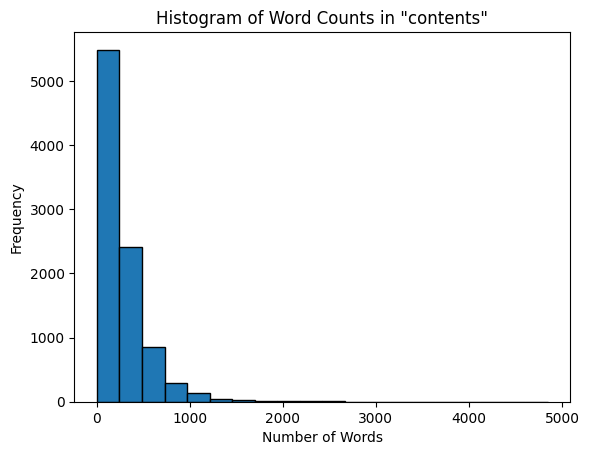

In [8]:
import matplotlib.pyplot as plt
word_counts = []

for example in ds['train']:
    content = example['contents']
    word_count = len(content.split())
    word_counts.append(word_count)

plt.hist(word_counts, bins=20, edgecolor='black')
plt.title('Histogram of Word Counts in "contents"')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()
